### 1. Import modules

In [2]:
from collections import deque
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC

### 2. Data preprocessing functions

This includes
- Converting dates to timestamps
- Calculating all the Gustas things for the previous _n_ games

In [20]:
METRICS = {
    "GoalsFullTime": ("FTHG", "FTAG"),
    "GoalsHalfTime": ("HTHG", "HTAG"),
    "GustasPoints":  ("HomePoints", "AwayPoints"),
    "GoalShots":     ("HS",   "AS"),
    "TargetShots":   ("HST",  "AST"),
    "Corners":       ("HC",   "AC"),
    "YellowCards":   ("HY",   "AY"),
    "RedCards":      ("HR",   "AR")
}


def create_date_stamp(date_string: str) -> int:
    # Transforms a dd/mm/yy or dd/mm/yyyy string to a timestamp
    if len(date_string.split("/")[-1]) == 4:
        return int(datetime.strptime(date_string, "%d/%m/%Y").timestamp())
    else:
        return int(datetime.strptime(date_string, "%d/%m/%y").timestamp())


def group_seasons(df: pd.DataFrame) -> np.array:
    # Adds a column to the df indicating which season it is
    seasons = []
    season_counter = 1
    prev_season_index = 0
    rows = df.iterrows()
    next(rows)

    for i, game in rows:
        curr_game_month = int(game.Date[4])
        prev_game_month = int(df.iloc[i - 1].Date[4])

        if curr_game_month - prev_game_month > 1:
            seasons += [season_counter]*(i - prev_season_index)
            season_counter += 1
            prev_season_index = i

    return pd.DataFrame({"Season": seasons})


def generate_gustas_points(df: pd.DataFrame) -> pd.DataFrame:
    # Caluclate Gustas' points for each game
    points = {"HomePoints": [0]*len(df), "AwayPoints": [0]*len(df)}
    score_map = {"H": (3, 0), "A": (0, 3), "D": (1, 1)}

    for i, (_, game) in enumerate(df.iterrows()):
        points["HomePoints"][i], points["AwayPoints"][i] = score_map[game["FTR"]]

    return pd.DataFrame(points)


# Generating game-specific data #


def calculate_window_metrics_by_team(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Calculates each metric for each team over the last n values
    global METRICS

    teams = df["HomeTeam"].unique()
    team_metric_deques = {t : {m : [0, deque([], maxlen=n)] for m in METRICS} for t in teams}
    metrics_df = {}

    # Fill columns
    for metric in METRICS:
        metrics_df[f"HomeLNG{metric}"] = []
        metrics_df[f"AwayLNG{metric}"] = []

    for _, game in df.iterrows():
        home = game.HomeTeam
        away = game.AwayTeam

        for metric in METRICS:
            home_metric, away_metric = METRICS[metric]

            # Add existing data to df
            home_metric_sum, home_deque = team_metric_deques[home][metric]
            away_metric_sum, away_deque = team_metric_deques[away][metric]

            if len(home_deque) == 0:
                metrics_df[f"HomeLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"HomeLNG{metric}"].append(home_metric_sum / len(home_deque))

            if len(away_deque) == 0:
                metrics_df[f"AwayLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"AwayLNG{metric}"].append(away_metric_sum / len(away_deque))

            # Include new data
            if len(home_deque) == n:
                team_metric_deques[home][metric][0] -= home_deque[0]
            
            if len(away_deque) == n:
                team_metric_deques[away][metric][0] -= away_deque[0]

            team_metric_deques[home][metric][0] += game[home_metric]
            team_metric_deques[home][metric][1].append(game[home_metric])

            team_metric_deques[away][metric][0] += game[away_metric]
            team_metric_deques[away][metric][1].append(game[away_metric])

    return pd.DataFrame(metrics_df)



# Only the below function should be used directly #


def format_df(df: pd.DataFrame) -> pd.DataFrame:
    # Applies all feature engineering etc that one could want
    df["DateStamp"] = df["Date"].map(create_date_stamp)
    df = df.join(group_seasons(df))
    df = df.join(generate_gustas_points(df))
    df = df.join(calculate_window_metrics_by_team(df, 10))

    return df
    

### 3. Load training and testing data

In [29]:
# Define features etc
FEATURES = [
    "HomeTeam",
    "AwayTeam",
    "Referee",
    "DateStamp",
#    "HomePSTGoalsFullTime",
#    "HomePSTGoalsHalfTime",
#    "HomePSTGustasPoints",
#    "HomePSTGoalShots",
#    "HomePSTTargetShots",
#    "HomePSTCorners",
#    "HomePSTYellowCards",
#    "HomePSTRedCards",
#    "AwayPSTGoalsFullTime",
#    "AwayPSTGoalsHalfTime",
#    "AwayPSTGustasPoints",
#    "AwayPSTGoalShots",
#    "AwayPSTTargetShots",
#    "AwayPSTCorners",
#    "AwayPSTYellowCards",
#    "AwayPSTRedCards",
    "HomeLNGGoalsFullTime",
    "HomeLNGGoalsHalfTime",
    "HomeLNGGustasPoints",
    "HomeLNGGoalShots",
    "HomeLNGTargetShots",
    "HomeLNGCorners",
    "HomeLNGYellowCards",
    "HomeLNGRedCards",
    "AwayLNGGoalsFullTime",
    "AwayLNGGoalsHalfTime",
    "AwayLNGGustasPoints",
    "AwayLNGGoalShots",
    "AwayLNGTargetShots",
    "AwayLNGCorners",
    "AwayLNGYellowCards",
    "AwayLNGRedCards",
]

CATEGORICAL_FEATURES = ["HomeTeam", "AwayTeam", "Referee"]

TARGET_NAMES = ["A", "D", "H"] # for presenting data


# Load datasets
df = format_df(pd.read_csv("data/epl-training.csv").dropna())

df = df[df.Season > 1] #NOTE THIS AVOIDS PROBLEMS WITH NaN VALUES BEFORE THE FIRST N GAMES
df.fillna(0, inplace=True)
df["FTR"] = df["FTR"].astype(str)

for ft in CATEGORICAL_FEATURES:
    df[ft] = df[ft].astype(str)


# Split X and y, training and testing

X = df[FEATURES]
y = df["FTR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [f for f in FEATURES if f not in CATEGORICAL_FEATURES]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



### 4. Create SVM model

Specifically, we are going to fit our model to our data and then predict the testing results

In [30]:
clf = SVC(probability=False)
clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)

### 5. Get performance metrics

We're going to print a classification report and print some graphs and charts now

              precision    recall  f1-score   support

           A       0.51      0.41      0.45       278
           D       0.39      0.03      0.05       249
           H       0.53      0.86      0.66       461

    accuracy                           0.53       988
   macro avg       0.48      0.43      0.39       988
weighted avg       0.49      0.53      0.45       988



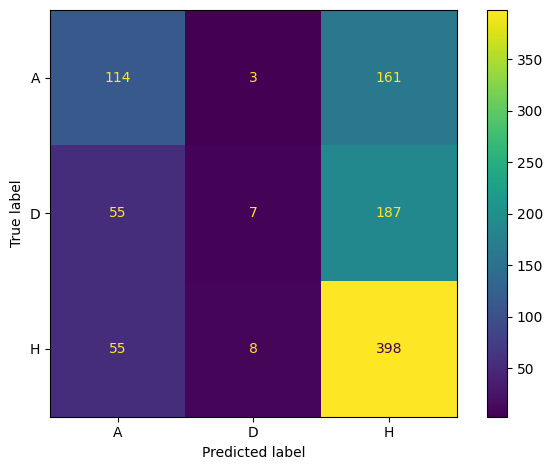

In [31]:
def evaluate_model(y_test, y_pred, target_names):
    print(classification_report(y_test, y_pred, target_names=target_names))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)
    plt.tight_layout()
    plt.show()


evaluate_model(y_test, y_pred, TARGET_NAMES)